# 07.2 Dynamics of the Risky Asset : Merton Jump–Diffusion
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:
- Build the jump–diffusion SDE combining Brownian motion and Poisson jumps.
- Derive the explicit solution of the Merton model.
- Understand the decomposition “Black–Scholes × product of jumps”.
- Simulate jump–diffusion sample paths.
- Visualise the impact of jump intensity and jump distribution.
- Prepare for pricing under jumps (07.3–07.4).

**This notebook**: 

Builds, solves, and simulates the Merton jump–diffusion dynamics: it derives the explicit closed-form solution combining a Black–Scholes diffusion with Poisson jumps, and provides simulation to visualise how jump intensity and jump distribution reshape asset paths depending on parameters, fat-tails, and skew.

# 1. Why add jumps to Black–Scholes?

The Black–Scholes diffusion:

$$dX_t = \mu X_t \, dt + \sigma X_t \, dW_t$$

generates continuous trajectories.

**But markets do not always evolve that way:**

- Sudden macro announcements,
- Bankruptcies, mergers, geopolitical shocks,
- Flash crashes,
- Overnight news.

Instantaneous jumps, not capturable by simple continuous diffusion. We therefore enrich the equation with a Poisson process that triggers jumps at intensity $\lambda$.


# 2. Setup of the Jump–Diffusion Model

We take:

- $W_t$: Brownian motion
- $N_t$: Poisson process with intensity $\lambda$
- $U_j$: i.i.d. jump amplitudes, $U_j \in (-1, \infty)$

All independent.

The risky asset $X_t$ follows:

$$dX_t = X_{t-}(\mu \, dt + \sigma \, dW_t + dZ_t), \quad Z_t = \sum_{j=1}^{N_t} U_j$$

Equivalent explicit SDE:

$$dX_t = \mu X_{t-} dt + \sigma X_{t-} dW_t + X_{t-} \sum_{j=1}^{N_t} U_j \, \delta_{t=\tau_j}$$

where each jump at time $\tau_j$ multiplies the price by $(1 + U_j)$.


# 3. Integral formulation

The jump–diffusion SDE can also be written in integral form:

$$X_t = X_0 + \int_0^t X_s (\mu \, ds + \sigma \, dW_s) + \sum_{j=1}^{N_t} X_{\tau_j^-} U_j$$

where:
- The first integral captures the **continuous drift and diffusion**,
- The sum captures the **discrete jumps** at Poisson arrival times $\tau_j$,
- $X_{\tau_j^-}$ denotes the price just before the $j$-th jump.


# 4. Explicit solution (Merton 1976)

By iterating over jump times, the exact closed form is:

$$X_t = X_0 \left(\prod_{j=1}^{N_t} (1 + U_j)\right) \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)$$

**Interpretation:**

- Same GBM component as Black–Scholes
- Multiplied by a random product of jump multipliers
- Number of jumps is Poisson($\lambda t$)
- If $N_t = 0$: recover pure Black–Scholes
- If $N_t = n$: the GBM is multiplied by $n$ random jump sizes


# 5. Simulation of jump–diffusion paths

**Parameters:**

- $X_0 = 100$
- $\mu, \sigma$ fixed
- Jump intensity $\lambda$
- Jumps $U_j \sim \mathcal{N}(m_J, s_J^2)$ or lognormal

We will observe occurence of jumps in red dots

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We def the function :

In [3]:
np.random.seed(42)

def simulate_jump_diffusion(
    X0=100, T=5.0, n_steps=1000,
    mu=0.05, sigma=0.2,
    lmbda=1.0,
    jump_mean=-0.05, jump_std=0.1
):
    dt = T / n_steps
    X = np.zeros(n_steps + 1)
    X[0] = X0
    
    # simulate Brownian increments
    dW = np.sqrt(dt) * np.random.randn(n_steps)
    
    # simulate Poisson jumps on each interval
    # N(dt) ~ Poisson(lambda * dt)
    N = np.random.poisson(lmbda * dt, size=n_steps)
    # jump amplitudes for each period
    U = np.random.normal(jump_mean, jump_std, size=n_steps)
    
    for t in range(n_steps):
        # diffusion part
        X[t+1] = X[t] * np.exp((mu - 0.5*sigma**2)*dt + sigma*dW[t])
        
        # jump part
        if N[t] > 0:
            X[t+1] *= (1 + U[t])**N[t]  # rare but possible multijump in dt
        
    return X

We plot :

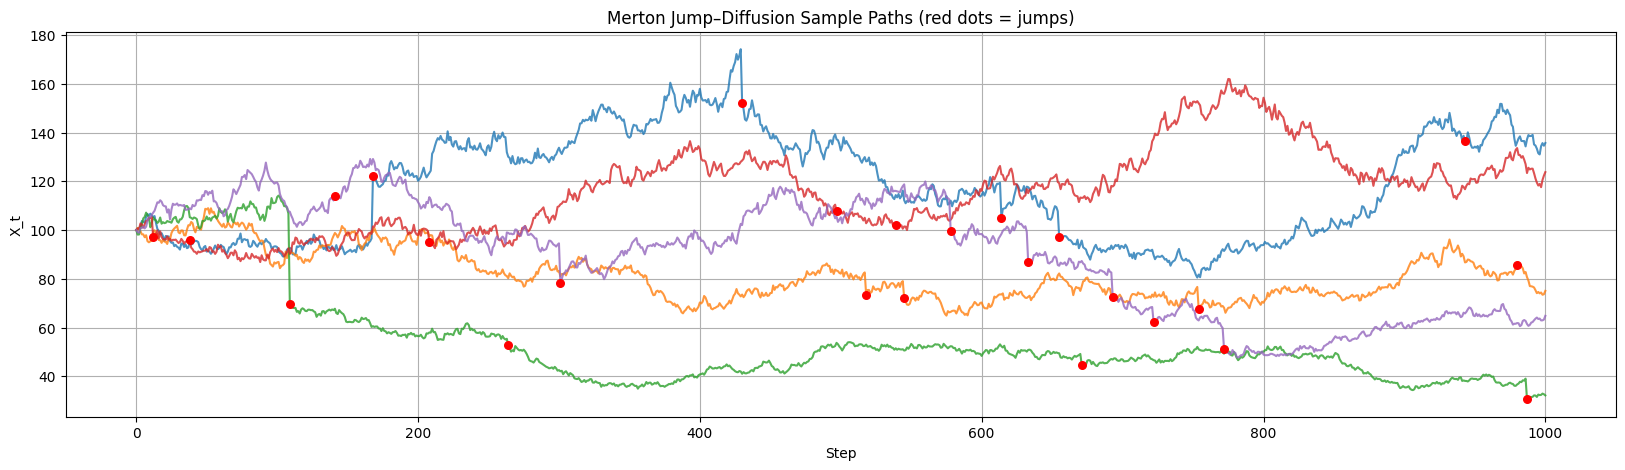

In [4]:
T = 5.0

plt.figure(figsize=(20,5))

for _ in range(5):
    dt = T / 1000
    X = np.zeros(1001)
    X[0] = 100
    
    # simulate Brownian increments
    dW = np.sqrt(dt) * np.random.randn(1000)
    
    # simulate Poisson jumps
    N = np.random.poisson(1.0 * dt, size=1000)
    U = np.random.normal(-0.08, 0.10, size=1000)
    
    jump_times = []
    jump_values = []
    
    for t in range(1000):
        # diffusion part
        X[t+1] = X[t] * np.exp((0.05 - 0.5*0.2**2)*dt + 0.2*dW[t])
        
        # jump part
        if N[t] > 0:
            jump_times.append(t+1)
            jump_values.append(X[t+1])
            X[t+1] *= (1 + U[t])**N[t]
    
    plt.plot(X, alpha=0.8)
    plt.scatter(jump_times, [X[i] for i in jump_times], color='red', s=30, zorder=5)

plt.grid(True)
plt.title("Merton Jump–Diffusion Sample Paths (red dots = jumps)")
plt.xlabel("Step")
plt.ylabel("X_t")
plt.show()


Each path behaves like a regular diffusion (a noisy GBM-style curve), but at random times we see sudden upward or downward jumps (red dots), caused by the Poisson jump component; these jumps create discontinuities that make the price paths more realistic and more volatile than pure Brownian motion.

# 6. Impact of jump intensity and jump distribution

## 6.1 Jump intensity λ :

| λ | Interpretation | Effect |
|---|---|---|
| 0 | no jumps | pure Black–Scholes |
| 0.5 | rare jumps | small skew |
| 1–2 | moderate | realistic skew/fat-tails |
| ≥5 | frequent jumps | discrete-time Lévy-like behavior |

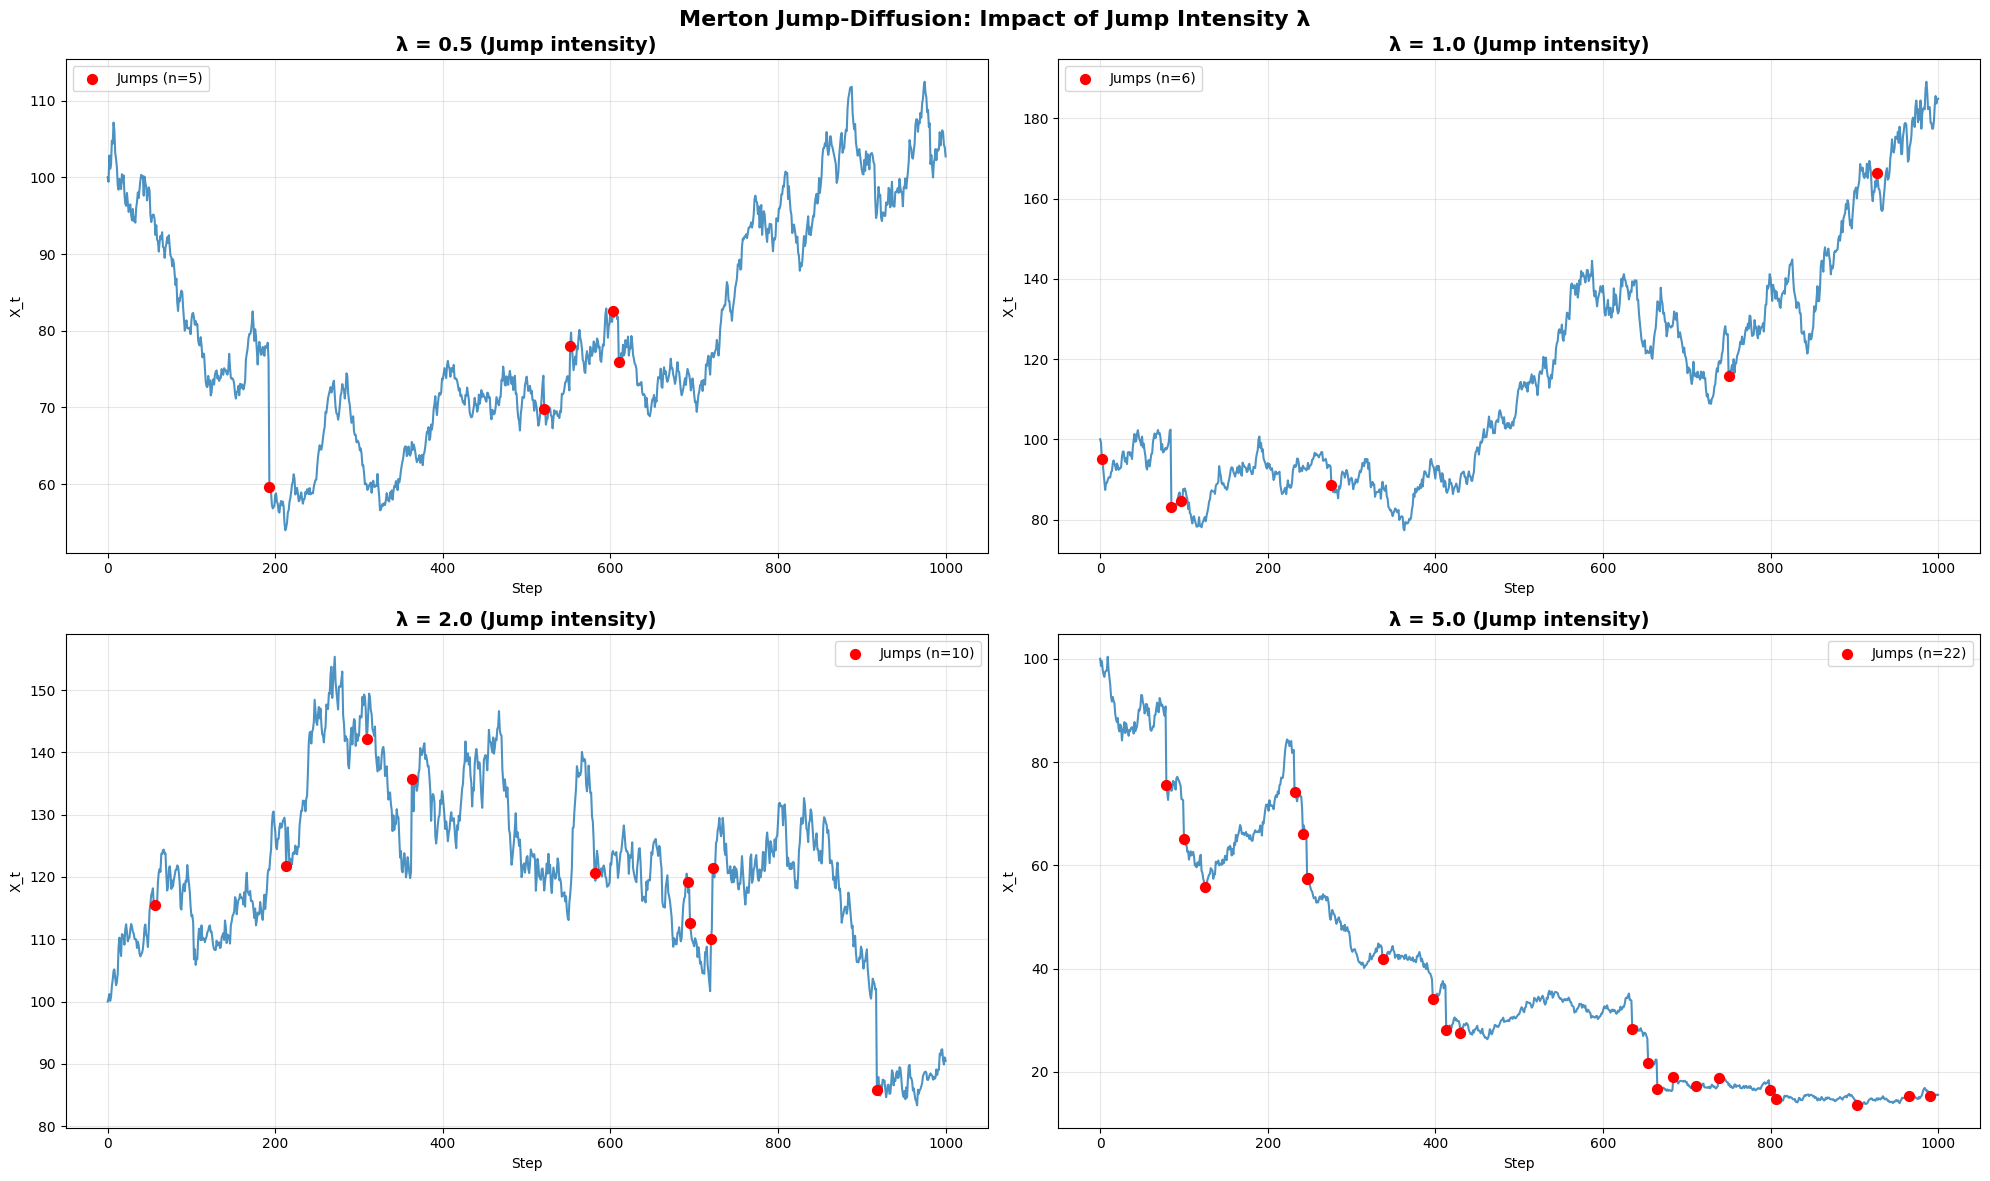

In [5]:
T = 5.0
dt = T / 1000

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

lambda_values = [0.5, 1.0, 2.0, 5.0]

for idx, lmbda in enumerate(lambda_values):
    ax = axes[idx]
    
    # Generate one sample path for this lambda
    X = np.zeros(1001)
    X[0] = 100
    
    # simulate Brownian increments
    dW = np.sqrt(dt) * np.random.randn(1000)
    
    # simulate Poisson jumps
    N = np.random.poisson(lmbda * dt, size=1000)
    U = np.random.normal(-0.08, 0.10, size=1000)
    
    jump_times = []
    jump_values = []
    
    for t in range(1000):
        # diffusion part
        X[t+1] = X[t] * np.exp((0.05 - 0.5*0.2**2)*dt + 0.2*dW[t])
        
        # jump part
        if N[t] > 0:
            jump_times.append(t+1)
            jump_values.append(X[t+1])
            X[t+1] *= (1 + U[t])**N[t]
    
    ax.plot(X, alpha=0.8, linewidth=1.5)
    ax.scatter(jump_times, [X[i] for i in jump_times], color='red', s=50, zorder=5, label=f'Jumps (n={len(jump_times)})')
    ax.grid(True, alpha=0.3)
    ax.set_title(f"λ = {lmbda} (Jump intensity)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Step")
    ax.set_ylabel("X_t")
    ax.legend()

plt.suptitle("Merton Jump-Diffusion: Impact of Jump Intensity λ", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

As λ increases, the paths exhibit more and more frequent discontinuities (red jumps), making the process progressively dominated by jumps rather than Brownian motion.

## 6.2 Jump mean / variance

- Negative jump mean (crashes) : implied volatility skew
- Large jump std : fat tails
- Frequent small jumps : looks like variance gamma

The grid below isolates the effect of jump parameters in a Merton jump–diffusion: for each value of λ (columns), all paths share the same Brownian noise and the same jump arrival times, so that the only differences come from the jump size distribution tested across rows (increasingly negative mean and larger volatility).

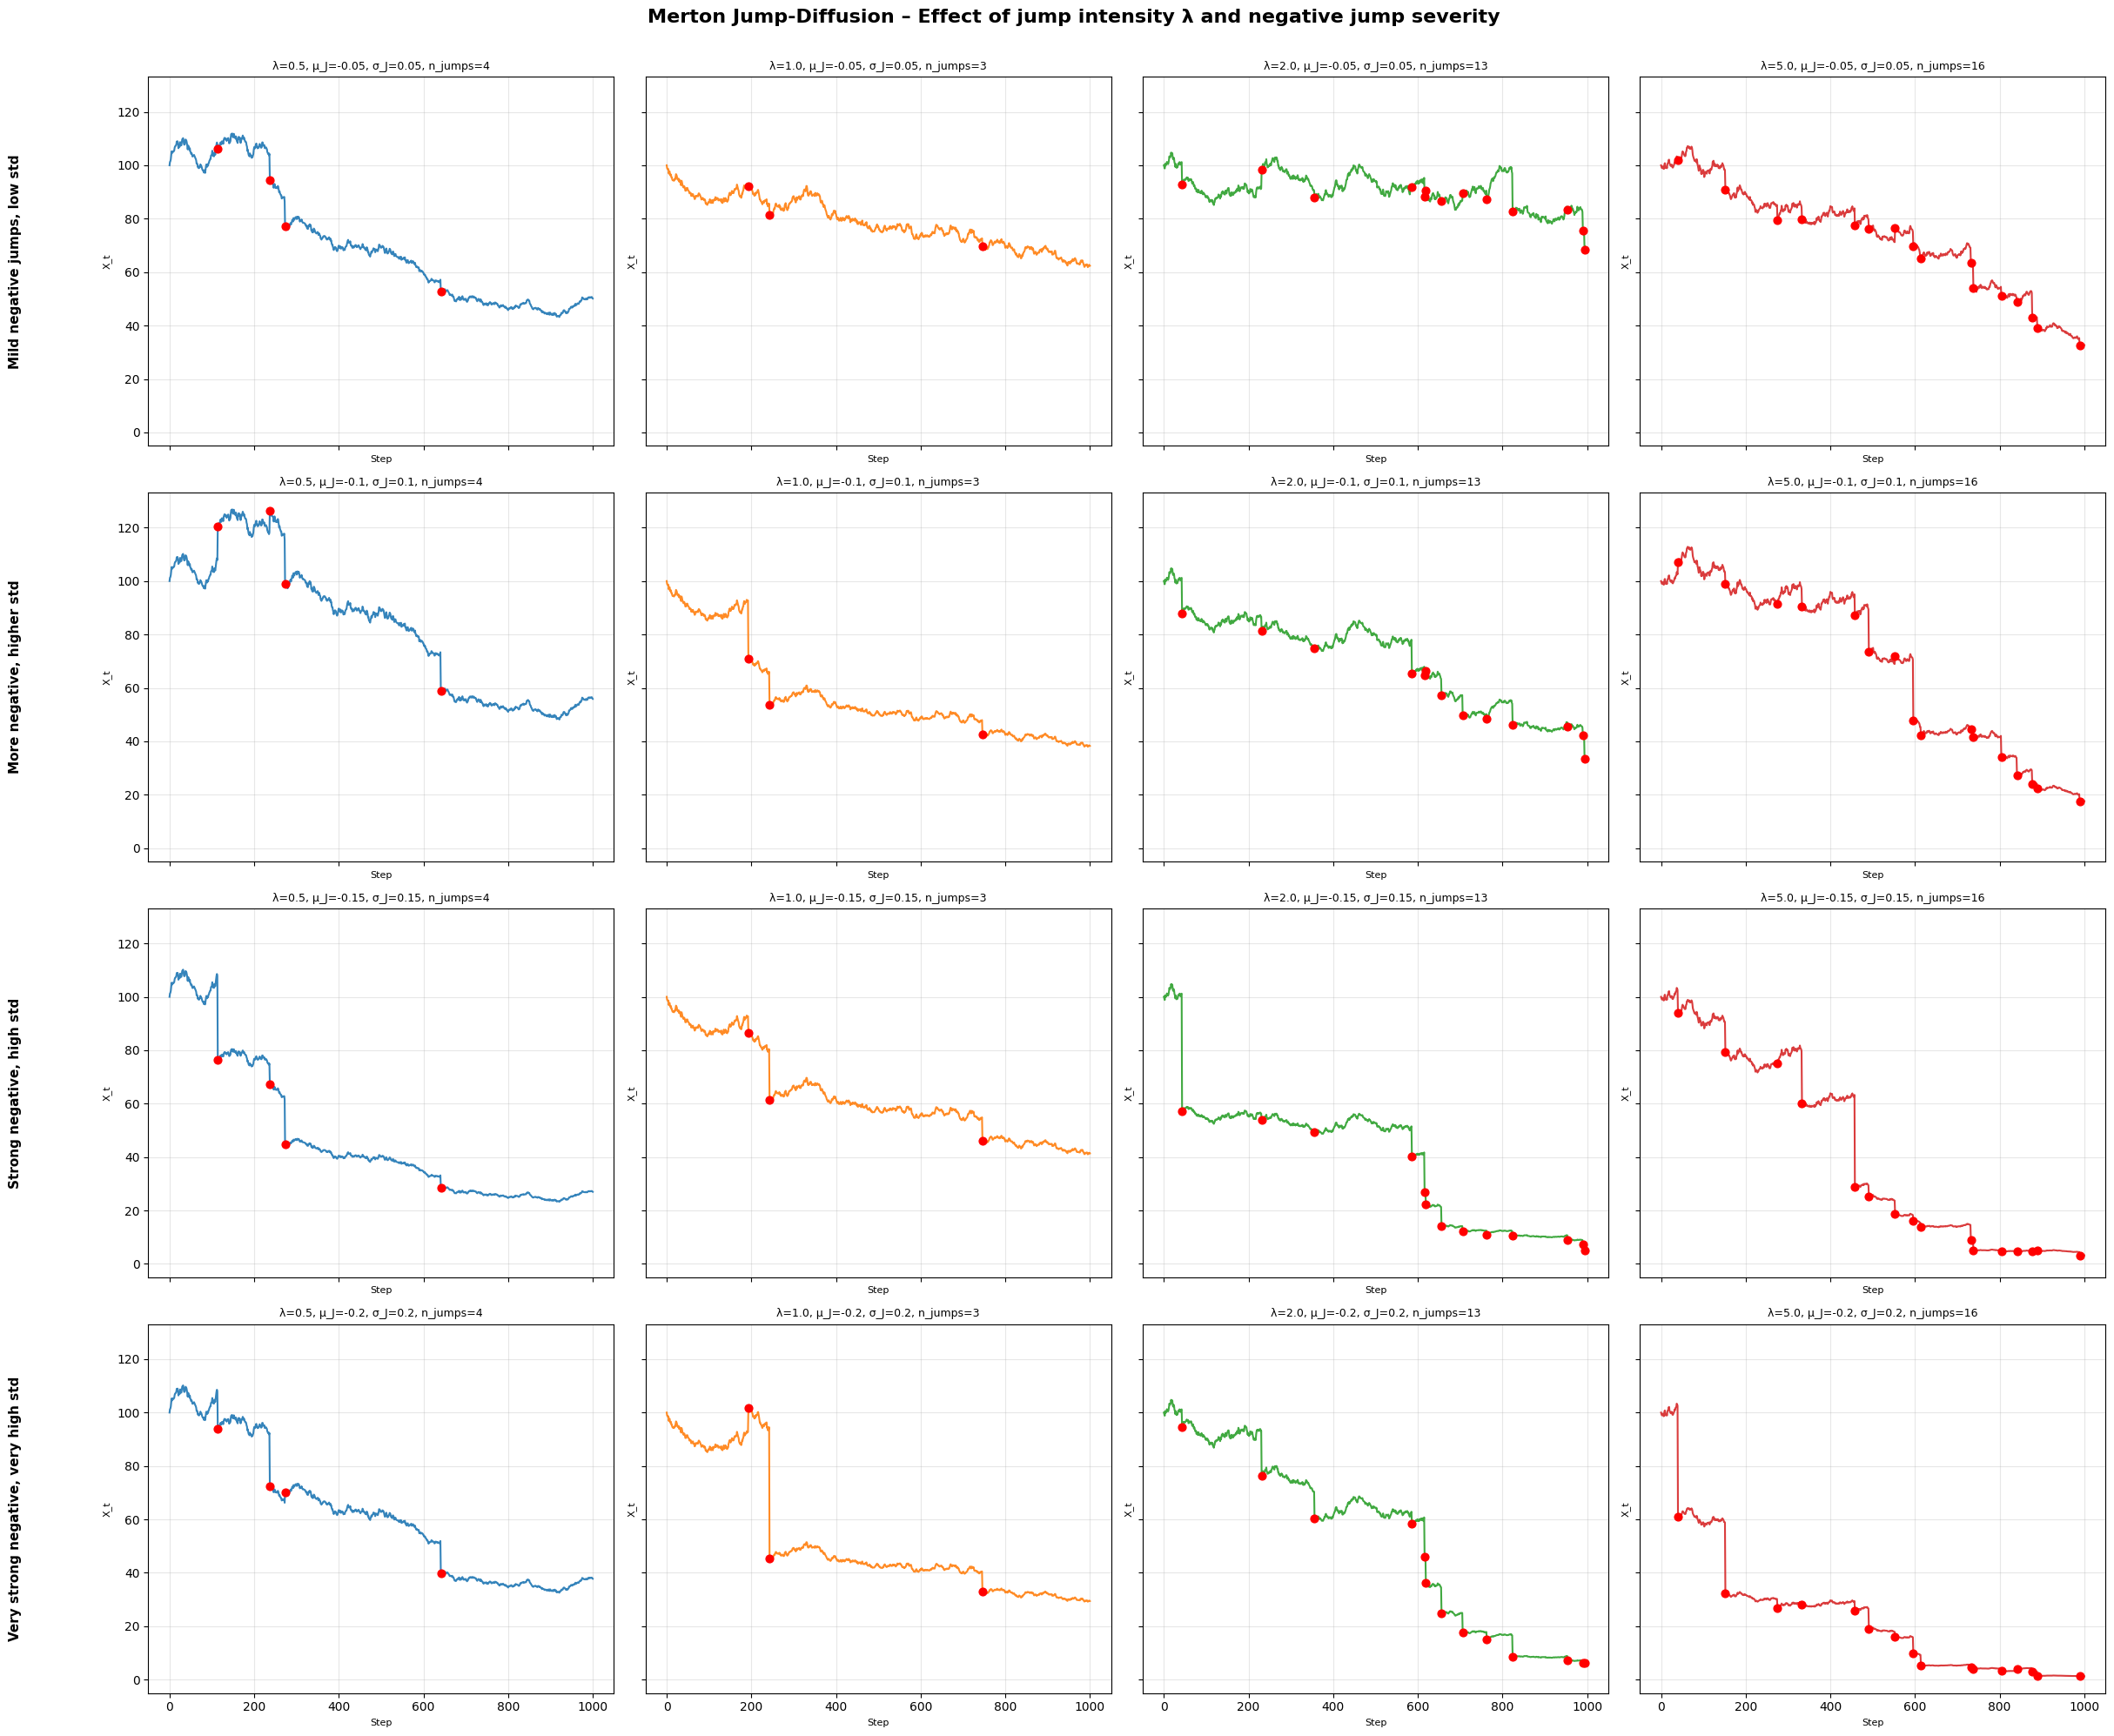

In [ ]:
T = 5.0
dt = T / 1000
n_steps = 1000

# Rows: jumps more and more negative and violent
jump_configs = [
    (-0.05, 0.05, "Mild negative jumps, low std"),
    (-0.10, 0.10, "More negative, higher std"),
    (-0.15, 0.15, "Strong negative, high std"),
    (-0.20, 0.20, "Very strong negative, very high std"),
]

# Columns: increasing λ (jump frequency)
lambda_values = [0.5, 1.0, 2.0, 5.0]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Fix Brownian and Poisson per lambda -> clean comparison between rows
sigma_diff = 0.10   # lower diffusion so jumps are visible
mu_diff = 0.0       # no directional drift, all comes from jumps

pre_dW = {}
pre_N = {}

np.random.seed(0)  # reproductible

for lmbda in lambda_values:
    pre_dW[lmbda] = np.sqrt(dt) * np.random.randn(n_steps)
    pre_N[lmbda] = np.random.poisson(lmbda * dt, size=n_steps)

fig, axes = plt.subplots(
    4, 4, figsize=(24, 20), sharex=True, sharey=True
)

for row_idx, (jump_mean, jump_std, config_label) in enumerate(jump_configs):
    for col_idx, lmbda in enumerate(lambda_values):
        ax = axes[row_idx, col_idx]

        X = np.zeros(n_steps + 1)
        X[0] = 100.0

        dW = pre_dW[lmbda]
        N = pre_N[lmbda]          # same jump times for this λ

        # jump sizes for THIS row (different mean/std)
        U = np.random.normal(jump_mean, jump_std, size=n_steps)

        jump_times = []

        for t in range(n_steps):
            # diffusion "soft"
            X[t + 1] = X[t] * np.exp(
                (mu_diff - 0.5 * sigma_diff**2) * dt + sigma_diff * dW[t]
            )

            # jumps of type (1 + U)^N
            if N[t] > 0:
                jump_times.append(t + 1)
                X[t + 1] *= (1 + U[t]) ** N[t]

        n_jumps = len(jump_times)

        ax.plot(X, alpha=0.9, linewidth=1.5, color=colors[col_idx])
        ax.scatter(jump_times, [X[i] for i in jump_times],
                   color='red', s=40, zorder=5)

        ax.grid(True, alpha=0.3)
        ax.set_title(
            f"λ={lmbda}, μ_J={jump_mean}, σ_J={jump_std}, n_jumps={n_jumps}",
            fontsize=9
        )
        ax.set_xlabel("Step", fontsize=8)
        ax.set_ylabel("X_t", fontsize=8)

        # row label on the left
        if col_idx == 0:
            ax.text(
                -0.3, 0.5, config_label,
                transform=ax.transAxes,
                fontsize=11, fontweight='bold', rotation=90,
                va='center'
            )

plt.suptitle(
    "Merton Jump-Diffusion – Effect of jump intensity λ and negative jump severity",
    fontsize=16, fontweight='bold', y=0.995
)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Moving from left to right, a larger λ produces more frequent jumps (more red dots), causing the price to deteriorate faster under identical shocks.  
Moving downward, the jump sizes become more negative and more volatile, so each jump produces a stronger downward move.  
Because the model is multiplicative, early large crashes reduce the level of the process, making later jumps appear visually smaller even though they remain severe in percentage terms.


# 7. Log-distribution of the asset

Conditional on $N_t = n$:

$$\log X_t = \log X_0 + \sum_{j=1}^{n} \log(1 + U_j) + \left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t$$

It is a  mixture of Gaussians 
It explains skew & kurtosis in implied volatility.


# 8. Visualising jump effects

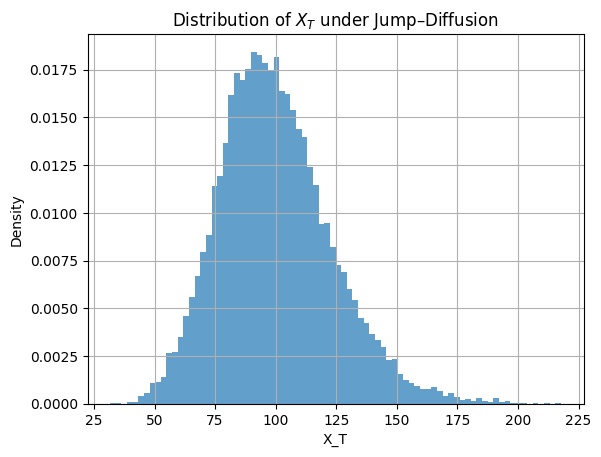

In [ ]:
X_T = []

for _ in range(20000):
    X_T.append(simulate_jump_diffusion()[-1])

plt.hist(X_T, bins=80, density=True, alpha=0.7)
plt.title("Distribution of $X_T$ under Jump–Diffusion")
plt.xlabel("X_T")
plt.ylabel("Density")
plt.grid(True)
plt.show()

We obtain a distribution that is: asymmetric (skewed), heavy-tailed (fat tails), sometimes bimodal when jumps are rare but large
